# Optimisation of finite element assembly computation

## Sum factorisation

Sum factorisation is a technique to reduce the algorithmic complexity which is particularly effective for high-order methods on tensor-product elements. Consider the Laplace operator $ a(u,v)=\nabla u \cdot \nabla v $, the local assembly tensor is:
$$ A_{ij}^K = \sum_{q=1}^{N_q}w_q\left( J_K^{-T}(X_q) \nabla \Phi_i(X_q)\cdot J_K^{-T} (X_q)\nabla\Phi_j(X_q)\right)\left\vert \mathsf{det}\left(J_K(X_q)\right) \right\vert $$

On a tensor-product element such as quadralaterals, FInAT takes advantage fo the internal structure of the finite element and rewrite the first derivatives of the basis functions as
$$ \frac{\partial\Phi_i}{\partial x_1}(X_q) \equiv D\mathbf{\Phi^1_{i_1q_1}}\mathbf{\Phi^2_{i_2q_2}}$$
$$ \frac{\partial\Phi_i}{\partial x_2}(X_q) \equiv \mathbf{\Phi^1_{i_1q_1}}D\mathbf{\Phi^2_{i_2q_2}}$$

with $\mathbf{\Phi^1}$, $\mathbf{\Phi^2}$ the tabulation of basis functions of the component element of the tensor-product element, and $D\mathbf{\Phi^1}$, $D\mathbf{\Phi^2}$ the tabulation of their first derivatives.

After expanding the matrix multiplication and dot product, the local tensor consists of summation of multiple terms such as
$$ \sum_{q_1,q_2} D\mathbf{\Phi^1_{i_1q_1}}\mathbf{\Phi^2_{i_2q_2}} \mathbf{\Phi^1_{j_1q_1}} D\mathbf{\Phi^2_{j_2q_2}} P_{q_1q_2} $$


This tensor product has indices $\left\{ q_1, q_2, i_1, i_2, j_1, j_2 \right\}$, requires $ O(N_{q_1}N_{q_2}N_{f_1}N_{f_2}N_{f_1}N_{f_2}) $ floating-pointer operations to compute. For order $n$ quadrilateral elements, both $N_{q_i}$ and $N_{f_i}$ are $O(n)$, so this assembly needs $O(n^6)$ FLOPs.

Sum factorisation rewrites the tensor contraction and lift out invariant terms to reduce the FLOPs. One possible way to rewrite this local tensor is to contract $q_2$ first, followed by $q_1$:
$$ \sum_{q_1} \mathbf{\Phi^1_{j_1q_1}} D\mathbf{\Phi^1_{i_1q_1}}\left( \sum_{q_2} \mathbf{\Phi^2_{i_2q_2}}  D\mathbf{\Phi^2_{j_2q_2}} P_{q_1q_2} \right)$$
This requires $O(N_{q_1}N_{q_2}N_{f_2}^2 + N_{q_2}N_{f_1}^2N_{f_2}^2)$, which is $O(n^5)$.

In general, for a $d$-dimentional tensor-product element built from intervals, sum factorisation reduces the complexity from $O(n^{3d})$ to $O(n^{2d+1})$. In Firedrake, TSFC searches all permutations of contraction indices for the best order to apply the contraction. This is feasible because we have at most 3 indices. More details about the algorithm and implemenation are available in \[1\].

## Argument factorisation

Apart from tensor contractions, TSFC also has optimisation passes that rewrites the expression based on associativity and distributivity, called argument factorisation. Argument factorisation takes advantage of the linearity of the differential form with respect to its arguments to create invariant loop-invariant expressions and reduces the FLOPs in the innermost loops.

Consider the simple expression $ a_{ij} = b_id_j + c_id_j $, the naive nested loop to compute $ a_{ij} $ is
```
for i
  for j
    a[i,j] = b[i]*d[j] + c[i]d[j]
```
However, we can rewrite the expression as $ a_{ij} = (b_i+c_i)d_j$, and the subexpression $b_i+c_i$ is invariant to index $j$, which can be hoisted into a temporary:
```
for i
  t = b[i] + c[j]
  for j
    a[i,j] = t*d[j]
```
Usually, there are multiple ways to rewrite the expression, which might require expansion using the distributive rule. TSFC solves a Interger Linear Programming model to choose the transformation. More details and compilicated examples can be found at the paper \[2\]

## Putting it together

TSFC organises the optimisation passes into *modes*. The default mode is *spectral*, which applies sum factorisation to determine the tensor contraction order, and at each level, apply argument factorisation to rearrange the expression. The modes can be selected by setting parameters. As an example, we look at the assembly of Laplace operator on a quadrilateral mesh:

In [1]:
from firedrake import *

We can create a quadrilateral mesh by extruding an interval:

In [2]:
mesh = UnitIntervalMesh(10)
mesh = ExtrudedMesh(mesh, 10)

In [3]:
n = 1
V = FunctionSpace(mesh, "CG", n)
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx

Let's first tell TSFC to use the *vanilla* mode, which does not apply sum factorisation or argument factorisation.
We need the low level interface from the form compiler to generate the local assembly kernel, let's import that from TSFC.

In [13]:
from tsfc import compile_form

In [14]:
kernel_vanilla, = compile_form(a, parameters={"mode": "vanilla"})

The COFFEE package provides facilities to inspect the local assembl kernels, such as estimating the number of floating-point operations needed.

In [15]:
from coffee.visitors import EstimateFlops

In [16]:
print("FLOPs using vanilla mode is {0}.".format(EstimateFlops().visit(kernel_vanilla.ast)))

FLOPs using vanilla mode is 626.


Now let's try the *spectral* mode. As mentioned earlier, sum factorisation is very effective in reducing the FLOPs for tensor product elements, such as the P elements on quadrilaterals.

In [17]:
kernel_spectral, = compile_form(a, parameters={"mode": "spectral"})
print("FLOPs using spectral mode is {0}.".format(EstimateFlops().visit(kernel_spectral.ast)))

FLOPs using spectral mode is 374.


The number of operations for assembling the local tensor is reduced to 374 from 626. We would expect the optimisation to be more effective for higher order discretisation. Let's check that:

In [18]:
from collections import defaultdict
flops = defaultdict(list)
ns = [1,2,3,4]
modes = ['spectral', 'vanilla']
for n in ns:
    V = FunctionSpace(mesh, "CG", n)
    u = TrialFunction(V)
    v = TestFunction(V)
    a = dot(grad(u), grad(v))*dx
    for mode in modes:
        kernel, = compile_form(a, parameters={"mode": mode})
        flops[mode].append(EstimateFlops().visit(kernel.ast))

<IPython.core.display.Javascript object>


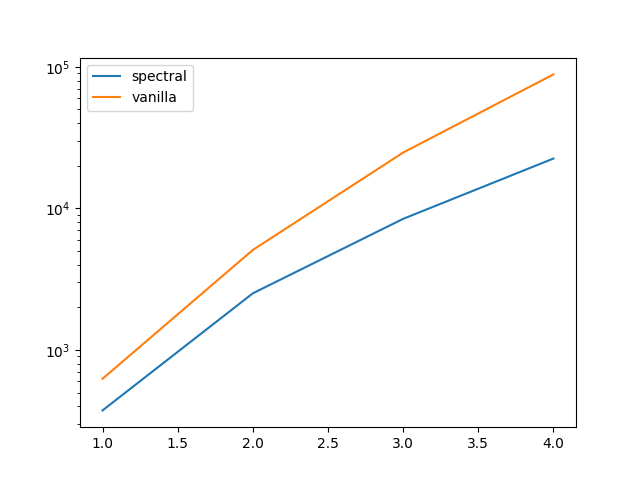

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.set_yscale('log')
for mode in modes:
    ax.plot(ns, flops[mode], label=mode)
ax.legend(loc='upper left')

## More to come ... 

### automated SIMD vectorisation with loo.py

SIMD vectorisation achieves significant fraction of peak performance on Intel Skylake Xeon with AVX512 instructions
![simd](image/skylake-simd.png)

## References

\[1\] Homolya, M., Kirby, R.C. and Ham, D.A., 2017. Exposing and exploiting structure: optimal code generation for high-order finite element methods. arXiv preprint arXiv:1711.02473.

\[2\] Luporini, F., Ham, D.A. and Kelly, P.H., 2017. An algorithm for the optimization of finite element integration loops. ACM Transactions on Mathematical Software (TOMS), 44(1), p.3.
